In [7]:
import cv2
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from skimage.color import gray2rgb

In [8]:
def find_image(im, tpl): # функция для нахождения шаблона на изображении
    im = np.atleast_3d(im) # приведение к 3-мерному массиву
    tpl = np.atleast_3d(tpl)
    H, W, D = im.shape[:3] # получение размеров массивов
    h, w = tpl.shape[:2]
    
    sat = im.cumsum(1).cumsum(0) # Нахождение кумулятивной суммы по вертикали и горизонтали
    tplsum = np.array([tpl[:, :, i].sum() for i in range(D)])  # получение суммы пикселей по глубине
    
    # поиск возможных совпадений по сумме
    iA, iB, iC, iD = sat[:-h, :-w], sat[:-h, w:], sat[h:, :-w], sat[h:, w:]
    lookup = iD - iB - iC + iA # нахождение суммы пикселей на каждом возможном месте шаблона

    # получение индексов возможных совпадений
    possible_match = np.where(np.logical_and.reduce([lookup[..., i] == tplsum[i] for i in range(D)]))
    
    # проверка точного соответствия
    for y, x in zip(*possible_match):
        if np.all(im[y+1:y+h+1, x+1:x+w+1] == tpl):
            return (y+1, x+1) # если точное соответствие найдено, то возвращаем координаты шаблона

    raise Exception("Image not found") # если не найдено точное соответствие, то выдаем исключение


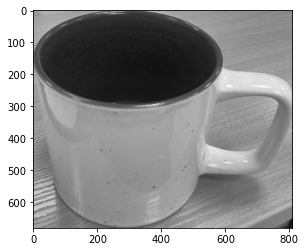

In [9]:
orig = 'img/20.jpg'
mask = cv2.imread(orig, 0)
im = gray2rgb(mask)

x1 = 90 # задание координат области, содержащей шаблон
x2 = 900
y1 = 500
y2 = 1180
tpl = im[y1:y2, x1:x2].copy() 
plt.imshow(tpl)
plt.savefig('1/11.jpg')

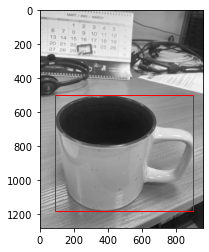

In [10]:
#orig1 = 'img/16.jpg'
#mask1 = cv2.imread(orig1, 0)
#im1 = gray2rgb(mask)

# Находим координаты верхней левой точки шаблона на изображении и сохраняем их в переменные y и x
y, x = find_image(im, tpl)
fig, ax = plt.subplots()
plt.imshow(im)

# Создаем прямоугольник с координатами (x, y) в левом верхнем углу и размером шаблона
rect = Rectangle((x, y), tpl.shape[1], tpl.shape[0], edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.savefig('2/11.jpg')
plt.show()


In [11]:
query_img = cv2.imread('img/11.jpg') # изображение, на котором нужно найти шаблон
original_img = cv2.imread('img/20.jpg')
original_img = original_img[y1:y2, x1:x2].copy() # обрезка шаблона
query_img_bw = cv2.cvtColor(query_img, cv2.IMREAD_GRAYSCALE)
original_img_bw = cv2.cvtColor(original_img, cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create() # Создаем объект orb, представляющий алгоритм ORB
# Находим ключевые точки с помощью детектора и вычисляем дескрипторы
queryKP, queryDes = orb.detectAndCompute(query_img_bw,None)
trainKP, trainDes = orb.detectAndCompute(original_img_bw,None)

# Создаем объект matcher, представляющий алгоритм сопоставления дескрипторов
# используем алгоритм наименьшего гамма расстояния и перекрестную проверку
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
matches = matcher.match(queryDes,trainDes) # Сопоставляем дескрипторы queryDes и trainDes с помощью matcher
# сортируем найденные соответствия по расстоянию между дескрипторами в порядке возрастания
matches = sorted(matches, key = lambda x:x.distance) 

# выбираем первые 40 найденных соответствий и создаем массив точек соответствия на изображениях
# запроса и оригинала, используя индексы найденных ключевых точек
src_pts = np.float32([queryKP[m.queryIdx].pt for m in matches[:40]]).reshape(-1,1,2)
dst_pts = np.float32([trainKP[m.trainIdx].pt for m in matches[:40]]).reshape(-1,1,2)

# вычисляем матрицу гомографии между массивом точек соответствия на изображении запроса и
# массивом точек соответствия на оригинальном изображении, используя алгоритм RANSAC и пороговое значение 5.0
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0) 
matchesMask = mask.ravel().tolist() # преобразование маски в список
pts = src_pts[mask==1] # выбираем точки, которые были использованы в вычислении гомографии
min_x, min_y = np.int32(pts.min(axis=0)) # находим минимальные координаты по оси X и Y
max_x, max_y = np.int32(pts.max(axis=0)) # находим максимальные координаты по оси X и Y

# создаем прямоугольник, ограничивающий найденный объект на изображении запроса
a = cv2.rectangle(query_img, (min_x, min_y), (max_x, max_y), 255, 2)

final_img = cv2.drawMatches(a, queryKP, original_img, trainKP, matches[:40], None) # рисуем объект на оригинальном изображении
cv2.imshow("Result", final_img) # показываем изображение с найденным объектом
cv2.waitKey() # ожидаем нажатия клавиши
isWritten = cv2.imwrite('2/10.png', final_img) # сохраняем изображение в файл

if isWritten:
    print('Image is successfully saved as file.') # выводим сообщение, если изображение успешно сохранено


Image is successfully saved as file.
